This script is part of the Molecular Systems Biology submission "Best practices in single-cell RNA-seq analysis: a tutorial". 

Here, we show that significant marker genes can be obtained for random data (simulated with a single cluster) after clustering. Clustering forces a separation of the cells into clusters based on gene expression data, which in turn allows differential testing to find significant differences between the expression of genes in the clusters.

In [1]:
import scanpy.api as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

import warnings
from rpy2.rinterface import RRuntimeWarning
from rpy2.robjects import pandas2ri

%load_ext rpy2.ipython

/Users/malte.luecken/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.3.2+78.g5034872 anndata==0.6.11 numpy==1.14.2 scipy==1.0.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


# Generate Data

We simulate single-cell gene expression data with a single cluster, dropout, no differentially expressed genes, for 1,000 cells and 10,000 genes.

In [3]:
%%R -o data
require(splatter)

n_cells <- 1000
n_genes <- 10000

params <- newSplatParams(seed=12345,
                        nGenes = n_genes,
                        batchCells = n_cells,
                        dropout.present = TRUE, 
                        dropout.shape = 0.95,
                        de.prob = 0)


sim <- splatSimulate(params)

data <- counts(sim)

In [4]:
data_df = pandas2ri.ri2py_dataframe(data)

In [5]:
adata = sc.AnnData(data_df.transpose())
adata.obs_names = adata.obs_names.astype(str)
adata.var_names = adata.var_names.astype(str)

# Pre-processing

In [6]:
#Basic QC filtering
sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=20)

filtered out 994 genes that are detected in less than 20 cells


In [7]:
adata

AnnData object with n_obs × n_vars = 1000 × 9006 
    obs: 'n_counts', 'n_genes'
    var: 'n_cells'

Note: We use CPM normalization here as it is reasonable to assume that our simulated data originally has the same number of molecules (given that we simulate a single cluster).

In [8]:
#Normalize the data
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

In [9]:
#Detect highly variable genes
sc.pp.filter_genes_dispersion(adata, flavor='cell_ranger', n_top_genes=4000, log=False, subset=False)

If you pass `n_top_genes`, all cutoffs are ignored.


In [10]:
# Pre-process and visualize
sc.pp.pca(adata, svd_solver='arpack', use_highly_variable=True, n_comps=10)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:04.17) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:03.32) --> added
    'X_umap', UMAP coordinates (adata.obsm)


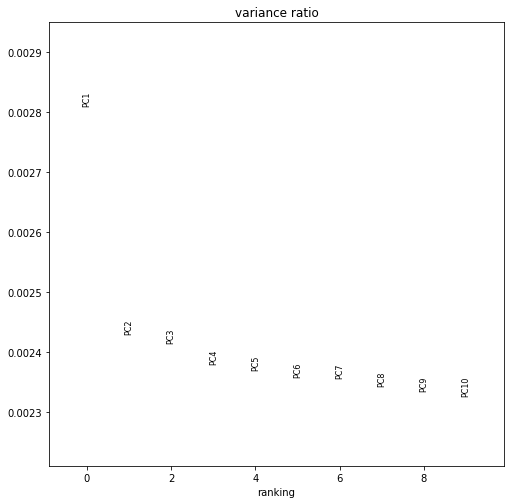

In [11]:
sc.pl.pca_variance_ratio(adata)

We only use 10 principal components here as we have a very simple system without much heterogeneity. Using more PCs would mean including smaller and smaller orthogonal noise contributions to visualize and cluster our data.

# Visualization

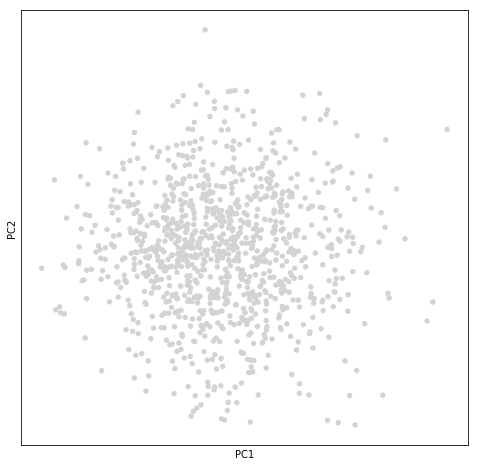

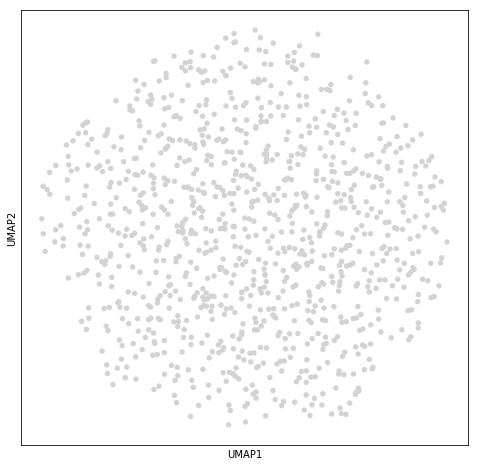

In [12]:
#Plot visualizations
sc.pl.pca(adata)
sc.pl.umap(adata)

# Clustering

In [13]:
#Cluster the data
sc.tl.louvain(adata, resolution=0.5, key_added='louvain')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.30) --> found 2 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


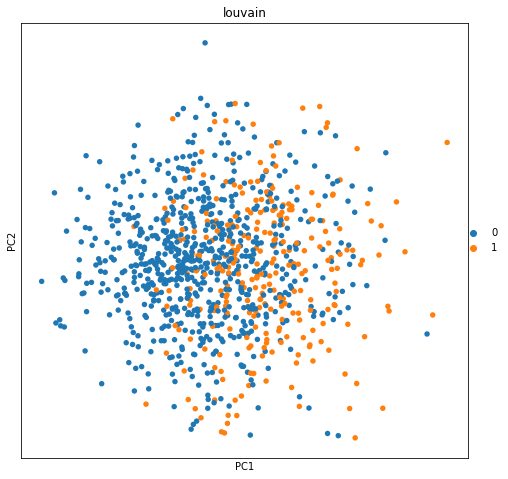

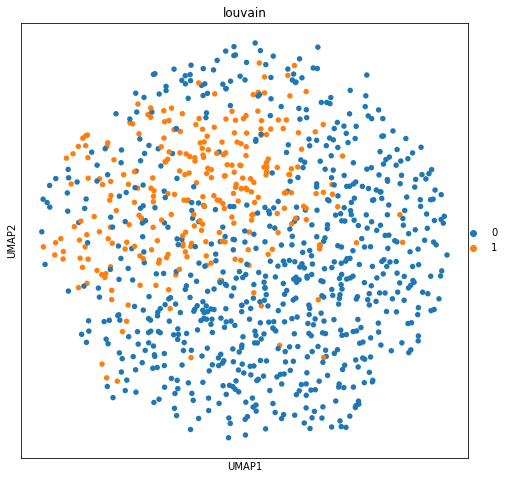

In [14]:
sc.pl.pca(adata, color='louvain')#, save='_splatter_pca_louvain.pdf')
sc.pl.umap(adata, color='louvain')

The above figures show that there is no inherent substructure in the data in UMAP or PCA visualizations as expected. The clustering however selects a subset of cells due to fluctuations in gene expression due to noise. As there is no uncertainty analysis inherent in the clustering method, this is to be expected.

# Marker genes

In [15]:
sc.tl.rank_genes_groups(adata, groupby='louvain', use_raw=False, method='t-test', key_added='rank_louvain', n_genes=9000)

ranking genes
    finished (0:00:00.19) --> added to `.uns['rank_louvain']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


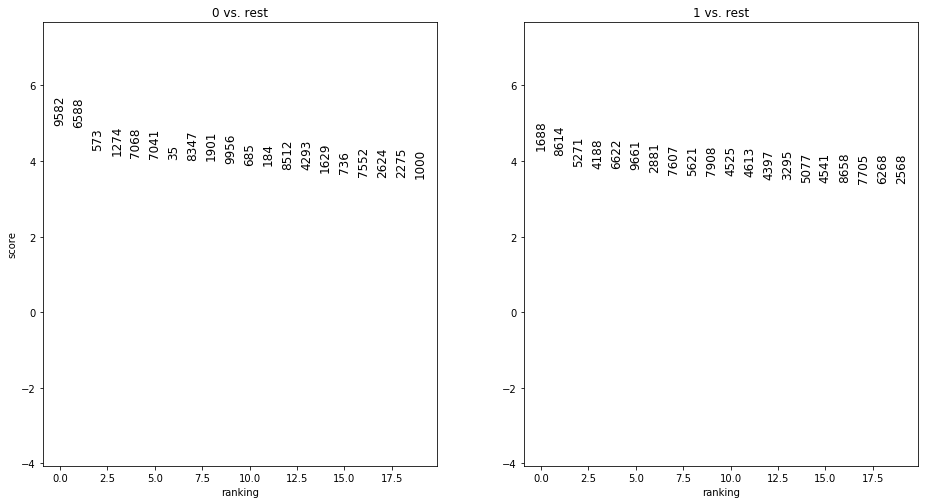

In [16]:
sc.pl.rank_genes_groups(adata, key='rank_louvain', groups=['0','1'], fontsize=12)


# P-value analysis

In [17]:
#Extract p-value data
pval_clust0 = [i[0] for i in adata.uns['rank_louvain']['pvals']]
pval_clust1 = [i[1] for i in adata.uns['rank_louvain']['pvals']]

/Users/malte.luecken/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


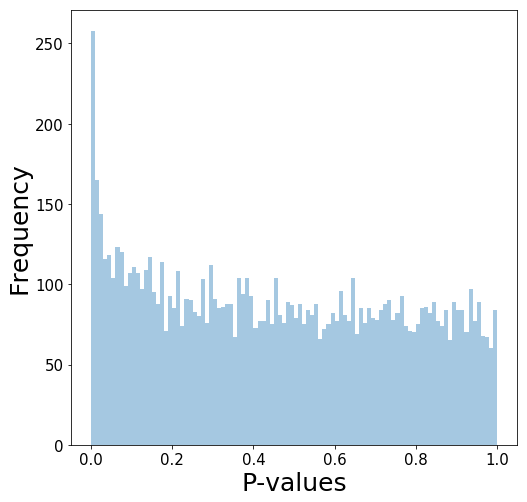

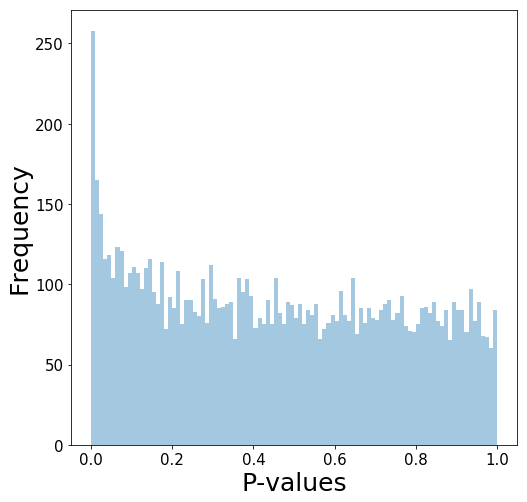

In [18]:
#Plot expected P-value distributions
lab_size = 25
tick_size = 15

p1 = sb.distplot(pval_clust0, kde=False, bins=100)
p1.set_xlabel("P-values",fontsize=lab_size)
p1.set_ylabel("Frequency",fontsize=lab_size)
p1.tick_params(labelsize=tick_size)
f1 = p1.get_figure()
#f1.savefig('figures/hist_pvals_clust0.pdf')
plt.show()

p2 = sb.distplot(pval_clust1, kde=False, bins=100)
p2.set_xlabel("P-values",fontsize=lab_size)
p2.set_ylabel("Frequency",fontsize=lab_size)
p2.tick_params(labelsize=tick_size)
f2 = p2.get_figure()
#f2.savefig('figures/hist_pvals_clust1.pdf')
plt.show()

Note that the distributions of p-values are essentially the same, as both tests are equal given that there are only 2 clusters. In each case 1 cluster is tested against the other cluster. The different marker genes only arise as we focus on over-expression for each cluster.

In [19]:
#Number of 'significant' marker gene after multiple testing correcting
signif_thresh = 0.05
n_signif_markers0 = np.sum([i[0] < signif_thresh for i in adata.uns['rank_louvain']['pvals_adj']])
n_signif_markers1 = np.sum([i[1] < signif_thresh for i in adata.uns['rank_louvain']['pvals_adj']])

print(n_signif_markers0)
print(n_signif_markers1)

9
5


We have significant marker genes after FDR correction for both clusters!